# LMR v2.1 vs Büntgen et al ensemble

For this application we quantify the distance between LMR2.1 vs the ensemble of Büntgen et al, 2021 (B21). Since the latter reconstructed only NH summer temperature, we load NH temperature from LMR. The notebook reproduces Figs 11-12. 

In [1]:
import pens
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xarray as xr
from scipy.stats import gaussian_kde 
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.gridspec as grid_spec
plt.style.use('default')
pens.set_style()

(<Figure size 1000x400 with 1 Axes>,
 <Axes: title={'center': 'LMR v2.1'}, xlabel='Year CE', ylabel='NHT [°C]'>)

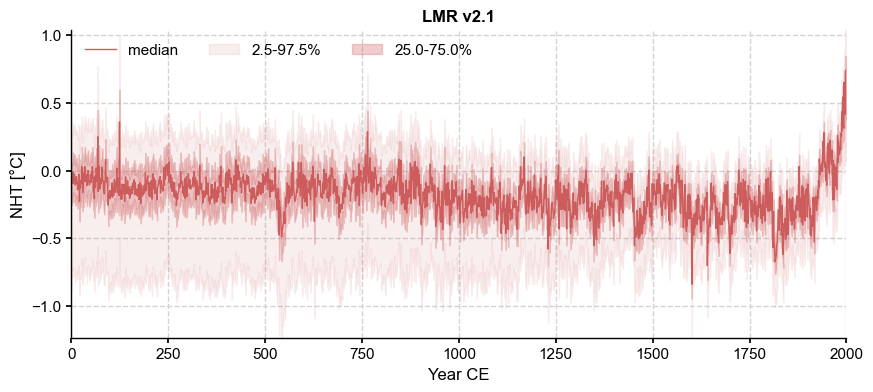

In [2]:
path = '../data/nhmt_MCruns_ensemble_full_LMRv2.1.nc'
LMR_nht = pens.EnsembleTS().load_nc(path, var='nhmt')
LMR_nht.label = 'LMR v2.1'
LMR_nht.time_name = 'Year CE'
LMR_nht.plot_qs(ylabel='NHT [\N{DEGREE SIGN}C]')

To choose the most appropriate temporal model, we plot the ensemble spectra:

In [3]:
psd  = LMR_nht.to_pyleo(verbose=False).spectral(method='mtm',settings={'NW':3})

Performing spectral analysis on individual series: 100%|██████████| 2000/2000 [07:38<00:00,  4.36it/s]


<Axes: xlabel='Period [years CE]', ylabel='PSD'>

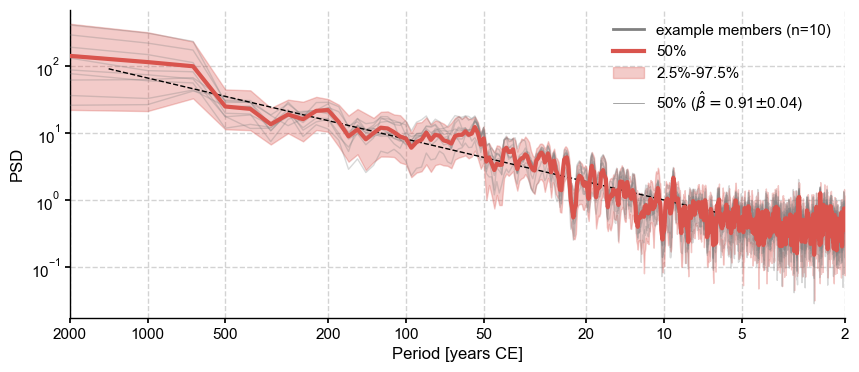

In [4]:
psd_med = psd.quantiles(qs=[0.5])
fig, ax = psd.plot_envelope()
psd_med.beta_est().plot(ax=ax)

In [5]:
psd_med.beta_est().beta_est_res['beta'][0]

0.9111839774282128

Let us thus resample according to a power-law, using the median slope as parameter:

In [6]:
LMR_nht_pl = LMR_nht.random_paths(model='power-law', param=psd_med.beta_est().beta_est_res['beta'][0],
                                  p=LMR_nht.nEns)

100%|██████████| 2000/2000 [00:36<00:00, 54.77it/s] 


Now load the B21 data from NOAA file:

In [7]:
path = '../data/buentgen2021recon.txt'  # modified for weird characters
df = pd.read_csv(path,skiprows=115,encoding='utf8', delim_whitespace=True, na_filter=False)
df.set_index('YearCE',inplace=True)
df.drop('Rmed',axis=1,inplace=True)
df.head()

,R1,R2,R3,R4,R5,R6,R7,R8,R9,R10,R11,R12,R13,R14,R15,Rmean
YearCE,,,,,,,,,,,,,,,,
1,-0.669554,-0.303244,-0.467243,-1.314425,-0.370,-0.573300,-0.685931,0.00,-0.225631,-0.379775,-0.435605,-0.355480,-0.862583,-0.430486,-0.505233,-0.433045
2,-0.448115,-0.532993,-0.556450,-1.058694,-0.219,-0.408151,-0.787994,-0.01,-0.217959,0.194776,-0.196139,-0.534690,-0.920016,0.068531,-0.401921,-0.428133
3,-0.519438,-0.488938,-0.572936,-1.226653,-0.154,-0.455268,-0.824891,-0.15,-0.326339,-0.144989,-0.299773,-0.628520,-0.793734,-0.085305,-0.476485,-0.472103
4,-0.231091,-0.312583,-0.505674,-1.496090,-0.107,-0.382701,-0.723426,-0.03,-0.181019,0.031611,-0.250385,-0.006623,-1.092359,0.024871,-0.375891,-0.240738
5,-0.585517,-0.314294,-0.558424,-1.038842,-0.080,-0.566686,-0.641757,-0.20,0.035370,-0.014277,-0.241596,-0.102210,-0.967983,-0.651108,-0.423380,-0.436359


Note: the column `Rmed`, inexplicably, is blank (or full of NaNs if `na_filter=True`). With the standard tab delimiter, the `Rmed` column is good, but the `R12` column is all NaNs. There does not appear to be a way to coerce pandas to simultaneously extract both columns from this txt file. Let's drop Rmed as it is not a primary reconstruction.

Now let's harmonize time axes for comparison with LMR:

In [8]:
df_LMR = df[df.index.isin(LMR_nht.time)]
LMR_nht = LMR_nht_pl.slice([1,2000])

We can now plot everything on the same graph:

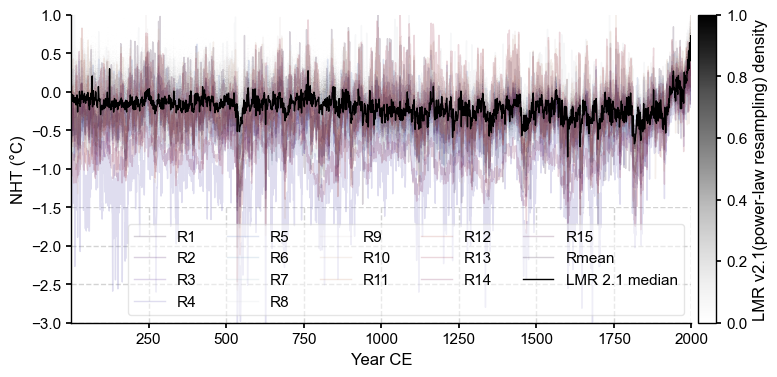

In [9]:
fs = (8,4)
fig, ax = LMR_nht.line_density(ylabel='NHT (\N{DEGREE SIGN}C)',label='LMR 2.1', figsize=fs)
cols = df.columns
clr = plt.cm.twilight_shifted(np.linspace(0,1,len(cols))) # define colors

for i, col in enumerate(cols):
    ax.plot(df.index,df[col],lw=1,alpha=0.2,color=clr[i],label=col)

LMR_nht.get_median().plot(color='black', linewidth=1, label = 'LMR 2.1 median', ax=ax)
ax.set_ylim(-3, 1)
ax.set_ylabel('NHT (\N{DEGREE SIGN}C)')
ax.legend(ncol=5, frameon=True, framealpha=0.5)

In [11]:
#fig.savefig('../figures/LMRvsB21_NHT_traces.pdf',dpi=300)

Let's quantify the plume distance to the median and mean reconstructions from B21

In [12]:
d_med = LMR_nht.plume_distance(df_LMR['Rmean'].values, max_dist=1)
print(d_med)

0.2631802270075316


How do these measures of distance that compare to the distance from plume to plume?

In [13]:
LMR_B21_plume_dist=LMR_nht.plume_distance(df_LMR.values, max_dist=0.8)
print(LMR_B21_plume_dist)

Computing inter-ensemble distance: 100%|██████████| 2000/2000 [00:00<00:00, 2906.84it/s]


0.2332913378865239


This is in the same ballpark.  The question becomes: are these differences "significant"? For reference, one could look at the distribution of distances between randomly chosen trajectories: 

Computing inter-ensemble distance: 100%|██████████| 2000/2000 [00:00<00:00, 2841.69it/s]


<Axes: ylabel='Density'>

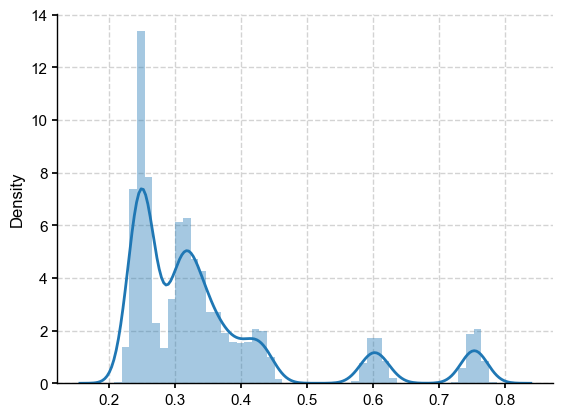

In [14]:
LMR_B21_dist = LMR_nht.distance(df_LMR.values)
sns.distplot(LMR_B21_dist, kde=True)

It is clear that there are multiple "clumps" corresponding to invidual reconstructions in the B21 ensemble. Overall, the ensemble distance of about 0.25 falls near the mode of this distribution, which is at the low end. Therefore, the sampling variations observed earlier (between 0.22 and 0.25 or so) seem relatively minor. 

Let us compare this to the intra-ensemble distances from LMRv2.1: 

Computing intra-ensemble distance among possible pairs: 100%|██████████| 1999000/1999000 [01:00<00:00, 33307.42it/s]


<Axes: ylabel='Density'>

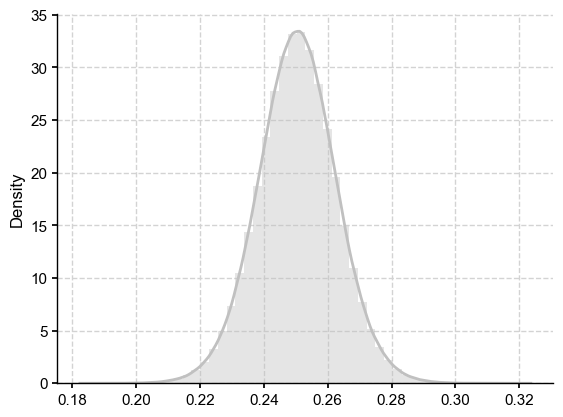

In [15]:
LMR_nht_pl_intra = LMR_nht.distance()
sns.distplot(LMR_nht_pl_intra,color='Silver')

In [16]:
LMR_nht_pl_intra_q95 = np.quantile(LMR_nht_pl_intra,0.95)

We are now ready to plot all three of these quanties on the same graph:

Text(0.5, 1.0, 'NHT distances')

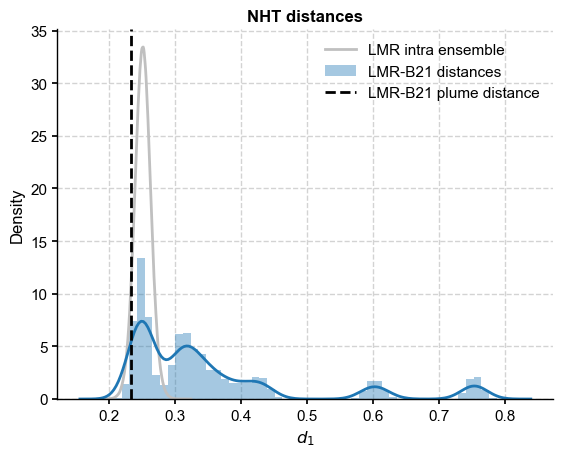

In [17]:
fig, ax = plt.subplots() 
sns.kdeplot(LMR_nht_pl_intra,label='LMR intra ensemble',color = 'silver')
sns.distplot(LMR_B21_dist,ax=ax,label='LMR-B21 distances',kde=True)
ax.axvline(x=LMR_B21_plume_dist,color="black", linestyle="--",label='LMR-B21 plume distance')
ax.set_xlabel(r'$d_1$')
ax.legend()
ax.set_title('NHT distances',fontweight='bold')

It would be more instructive to redo this with B21 reconstructions separated by color:

Text(0.5, 1.0, 'LMRv2.1 to B21 NHT distances')

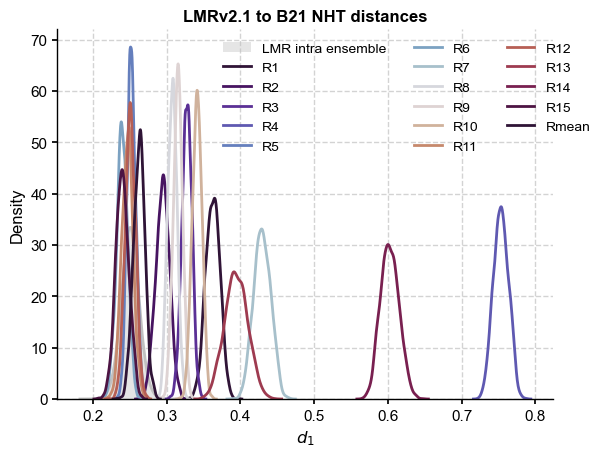

In [18]:
fig, ax = plt.subplots() 
sns.distplot(LMR_nht_pl_intra,ax=ax,label='LMR intra ensemble',color = 'silver')
dist = np.empty((LMR_nht.nEns,df_LMR.shape[1]))
for i, col in enumerate(cols):
    dist[:,i] = LMR_nht.distance(y=df_LMR[col])
    sns.kdeplot(dist[:,i],ax=ax,color=clr[i],label=col)
#ax.axvline(x=LMR_B21_plume_dist,color="black", linestyle="--",label='LMR-B21 plume distance')
ax.set_xlabel(r'$d_1$')
ax.legend(ncol=3, fontsize=10, bbox_to_anchor=(1.1, 1))
ax.set_title('LMRv2.1 to B21 NHT distances',fontweight='bold')

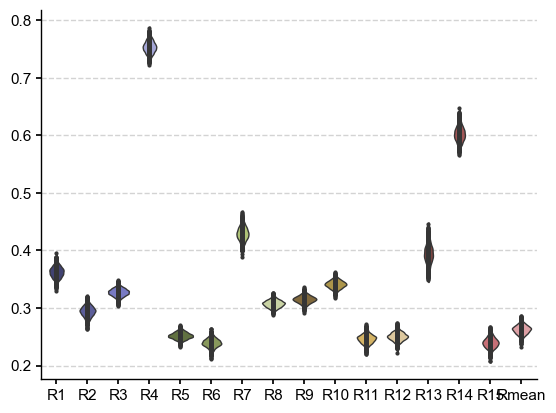

In [19]:
dist_df = pd.DataFrame(data=dist,columns=cols)
fig, ax = plt.subplots() 
sns.violinplot(data=dist_df, palette="tab20b", ax=ax, inner="points", orient="v", bw=.2, cut=1, linewidth=1)
x = np.linspace(0,1,10)

Try as a ridgeplot, modified from [this guy](https://matplotlib.org/matplotblog/posts/create-ridgeplots-in-matplotlib/).

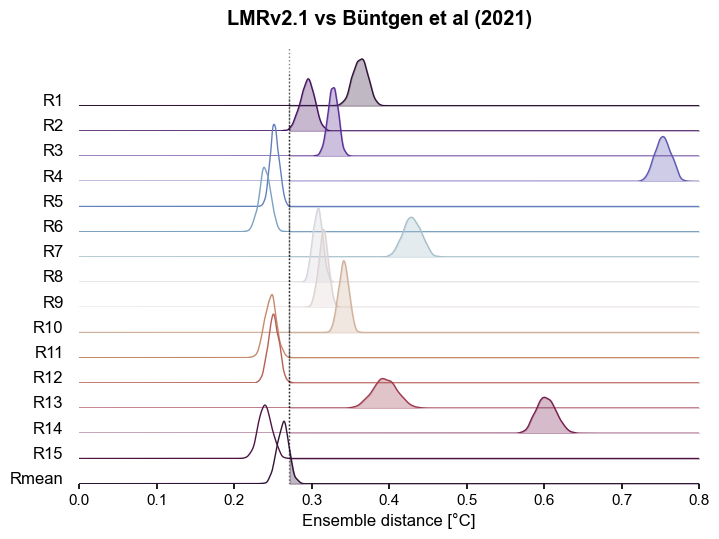

In [26]:
gs = grid_spec.GridSpec(df_LMR.shape[1],1)
fig = plt.figure(figsize=(8,6))
xd = np.linspace(0,1, 1000)
bw = 'silverman' 
ax_objs = []

for i, col in enumerate(cols):
    kde = gaussian_kde(dist[:,i],bw_method=bw)
    prob = kde.integrate_box_1d(LMR_nht_pl_intra_q95, xd.max()) # estimate probability of positive change
    
    # creating new axes object
    ax_objs.append(fig.add_subplot(gs[i:i+1, 0:]))

    # plotting the distribution
    xp = xd[xd>LMR_nht_pl_intra_q95]
    ax_objs[-1].fill_between(xp, kde(xp),alpha=0.3, color=clr[i])
    ax_objs[-1].plot(xd, kde(xd), linewidth=1, label=col, color=clr[i])

    # setting uniform x and y lims
    ax_objs[-1].set_xlim(0,0.8)
    ax_objs[-1].set_ylim(0,70)
    # make background transparent
    rect = ax_objs[-1].patch
    rect.set_alpha(0)
    # remove borders, axis ticks, and labels
    ax_objs[-1].set_yticklabels([])
    ax_objs[-1].set_yticks([])
    
    if i == len(cols)-1:
        ax_objs[-1].set_xlabel("Ensemble distance [\N{DEGREE SIGN}C]", fontsize=12)
        ax_objs[-1].grid(False)
    else:
        ax_objs[-1].set_xticklabels([])
        ax_objs[-1].set_xticks([])

    spines = ["top","right","left","bottom"]
    for s in spines:
        ax_objs[-1].spines[s].set_visible(False)

    ax_objs[-1].text(-0.02,0,col,fontsize=12,ha="right")
    # add the critical value
    if i > 0:
        ax_objs[-1].axvline(x=LMR_nht_pl_intra_q95, color="black",
                            linestyle=":",alpha=0.5,linewidth=1,label=r'$q_{95}$')
        
#handles, labels = ax_objs[-1].get_legend_handles_labels()
#fig.legend(handles, labels, loc='upper center')       
gs.update(hspace=-0.7)
fig.suptitle("LMRv2.1 vs Büntgen et al (2021)", fontweight="bold",y=.90)
fig.tight_layout()

The B21 ensemble is made of reconstructions sharing the same input data but differing in methodology. Some of the methods result in ensemble members that are within the range of LMR intra-ensemble distances (up to 0.3), but anything beyond that is decidedly incompatible. Interestingly, most of the ensemble mean (Rmean) trajectories are compatible at the 95% level.

The plume distance between the ensembles is around 0.23, which is at the low-end of both distance distributions. What should we make of it? Is it a useful measure on its own?


B21 is a bit of a Frankenstein one, where the output of various methods was aggregated together, so we would expect multimodality, in which case a single scalar metric is all but guaranteed to fail. 

It is clear that homogeneous ensembles like LMR fare better on this point, and are more suited to a metric like the plume distance.